Autorzy: Weronika Hilaszek, Karolina Surówka
---



# Gra **GoldDigger**

**Opis gry**

Agent porusza się po planszy o wymiarach 4x12. Jego zadaniem jest znaleźć całe zakopane złoto. Jednakże nie jest to takie trywialne zadanie ze względu na istniejące bomby. Są dwa rodzaje bomb. Jedne są zabójcze (gra się kończy), drugie powodują utratę jednego z 3 żyć agenta oraz cofnięcie go o jedną komórke do tyłu. Gra kończy się zwycięstwem, w przypadku gdy gracz wykopie całe znajdujące się na planszy złoto.

**Przestrzeń ruchu**

Agent może wykonywać jedno z 4 możliwych ruchów w danej iteracji. Ich oznaczenia znajdują się poniżej.

    0:  w prawo

    1: do góry

    2: w lewo

    3: w dół

**Przestrzeń stanów**

Dla ułatwienia poruszania się po planszy została zastosowana przestrzeń stanów. Każda komórka ma swój unikatowy numer stanu. Agent na pozycji początkowej zajmuje stan nr **36**. Złoto znajduje się na pozycjach: **0**, **8**, **16**, **38**, zabójcze bomby: **47**, lekkie bomby: **4**, **27**, **43**.

In [ ]:
"""
States or Observations:
0   1   2   3   4   5   6   7   8   9   10  11
12  13  14  15  16  17  18  19  20  21  22  23
24  25  26  27  28  29  30  31  32  33  34  35
36  37  38  39  40  41  42  43  44  45  46  47
"""

**Nagroda**

Każdy krok wiąże się z nagrodą równą -1. Gdy gracz wejdzie na zabójczą bombę otrzymuje nagrodę -100, gdy na lekką -50. Znalezienie złota wiąże się z otrzymaniem 200 punktów.

## **SARSA**

Uczenie algorytmu pokonywania trasy do celu wykorzystuje algorytm Sarsa. Jego nazwa jest akronimem od wartości, które przyjmuje i zwraca: s, a, r, s', a'. Łatwo zauważyć, że wykorzystuje on nie tylko obecny stan, wykonywaną akcję oraz zwrócone przez środowisko nagrodę i następny stan, ale również akcję następną, którą agent wykonuje w późniejszym kroku czasowym.

Dopóki nie zostanie osiągnięty stan końcowy algorytm wykonuje akcję a (zapamiętaną w poprzednim kroku czasowym) i obserwuje nagrodę r oraz kolejny stan s'. Wybiera następną akcję a' wedle obranej strategii i zapamiętajuje ją.
Aktualizuje również wartość oczekiwanej nagrody według wzoru:

    Q(s, a) + α(r + γ*Q(s', a) - Q(s, a)).

# Implementacja

In [ ]:
%pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.5 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import matplotlib.pyplot as plt

In [ ]:
class GoldDigger(gym.Env):
  def __init__(self, size = (4,12), n_episodes=500, epsilon=1.0, alpha = 0.01, gamma =0.9):  ## potrzebne parametry
    self.size = size
    self.board = np.zeros((self.size[0], self.size[1]))
    self.observation_space = spaces.Box(low=0, high=2, shape=(self.size[0], self.size[1]), dtype=int)
    self.action_space = spaces.Discrete(4)
    self._action_to_direction = {
            0: np.array([1, 0]), ## "right"
            1: np.array([0, 1]), ## "up"
            2: np.array([-1, 0]),## "left"
            3: np.array([0, -1]),## "down"
        }
    self.current_position = (3, 0)  ### (row, column)

    self.deadly_bombs_states = [47]
    self.light_bombs_states = [4, 43, 27]
    self.found_light_bombs_states = []
    self.gold_states = [0, 38, 16, 8]
    self.won_gold_states = []
    self.game_over = False

    self.n_episodes = n_episodes
    self.epsilon = epsilon
    self.epsilon_decay = self.epsilon / (self.n_episodes / 2)
    self.final_epsilon = 0.1

    self.alpha = alpha
    self.gamma = gamma

    self.Q = np.zeros((48, 4))
    self.paths_list = []
    self.rewards_list = []
    self.steps_counter = 0
    self.lives_counter = 3

  def check_gold_found(self, state):  ## Sprawdzenie czy znaleziono złoto
    if state in self.gold_states:
      # print("Congratulation!! You found a gold!!")
      if state not in self.won_gold_states:
        self.won_gold_states.append(state)
        self.gold_states.remove(state)
      return True
    return False

  def check_light_bomb_found(self, state): ## Sprawdzenie czy wybuchła lekka bomba
    if state in self.light_bombs_states:
      # print("The light bomb found !!")
      self.found_light_bombs_states.append(state)
      self.light_bombs_states.remove(state)
      self.lives_counter -= 1
      # print(f"You have {self.lives_counter} lives left !!")
      return True
    return False

  def check_game_over(self,state) -> bool:  ## Sprawdzenie czy gra się skończyła
    if self.lives_counter == 0:
      # print("YOU DIED 3 TIMES!!")
      return True
    if all(state in self.won_gold_states for state in self.gold_states):
      # print("YOU FOUND ALL GOLD!!! \n\n")
      return True
    if state in self.deadly_bombs_states:
      # print("UPSS IT WAS DEADLY BOMB \n\n")
      return True
    return False

  def get_state(self, position):  ## Obliczenie nr stanu na podstawie pozycji
    return position[0]*12 + position[1]

  def reset(self): ## Zresetowanie rozgrywki
    self.board =  np.zeros((self.size[0], self.size[1]))
    self.current_position = (3, 0)
    self.steps_counter = 0
    self.lives_counter = 3

    self.deadly_bombs_states = [47]
    self.light_bombs_states = [4, 43, 27]
    self.found_light_bombs_states = []
    self.gold_states = [0, 38, 16, 8]
    self.won_gold_states = []

    return self.get_state(self.current_position)

  def get_reward(self) -> int:  ## Wyznaczenie nagrody w zależności od zajęteo stanu
    if self.get_state(self.current_position) in self.deadly_bombs_states:
      return -100
    if self.get_state(self.current_position) in self.light_bombs_states:
      return -50
    if self.get_state(self.current_position) in self.gold_states:
      return 200
    return -1

  def step_back(self, state):  ### Przesunięcie agenta o jedną komórke do tyłu
    # print("Step back!")
    self.current_position[1] -= 1

  def step(self, action): ## Wykonanie ruchu
    self.steps_counter += 1
    move_direction = self._action_to_direction[action]
    self.current_position += move_direction

    ## Sprawdzenie czy pozycja nie wykracza poza planszę, jeśli tak agent zostaje na tym samym miejscu
    if self.current_position[0] < 0  or self.current_position[0]>3 or self.current_position[1]<0 or self.current_position[1] > 11:
      self.current_position -= move_direction
    self.check_gold_found(self.get_state(self.current_position))
    # self.render()
    self.game_over = self.check_game_over(self.get_state(self.current_position))
    reward = self.get_reward()
    ## Sprawdzenie czy wybuchła lekka bomba, jeśli tak agent zostaje przesunięty
    if self.check_light_bomb_found(self.get_state(self.current_position)):
      self.step_back(self.current_position)
      # self.render()
      self.game_over = self.check_game_over(self.get_state(self.current_position))

    return self.get_state(self.current_position), reward

  def epsilon_greedy_policy(self, state):  ## Wyznaczenie ruchu
    if np.random.rand() < self.epsilon:
        return np.random.choice(4)
    else:
        return np.argmax(self.Q[state])

  def render(self):   ## Funkcja wyświetlająca planszę po każdym ruchu
    print(f"STEP: {self.steps_counter}")
    print("========================")
    for i in range(self.size[0]):
        for j in range(self.size[1]):
            if i == self.current_position[0] and j == self.current_position[1]:
                print("A", end=" ")
            elif self.get_state((i,j)) in self.won_gold_states:
                print("-", end=" ")
            elif self.get_state((i, j)) in self.gold_states:
                print("$", end=" ")
            elif self.get_state((i, j)) in self.light_bombs_states:
                print("*", end=" ")
            elif self.get_state((i, j)) in self.deadly_bombs_states:
                print("B", end=" ")
            else:
                print("-", end=" ")
        print()
    print("========================\n\n")


  def decay_epsilon(self): ## Modyfikacja parametru epsilon
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

  def update_q_table(self, state, action, reward, next_state, next_action): ## Aktualizacja tablicy Q
    """
    Dla wersji Sarsa:
    Q(S, A) <- Q(S, A) + [α * (r + (γ * max(Q(S', A')))) -  Q(S, A)]
    """
    self.Q[state, action] = self.Q[state, action] + self.alpha * (reward + self.gamma * self.Q[next_state, next_action] - self.Q[state, action])

  def play_single_episode(self):  ### Rozegranie pojedynczej rozgrywki
    reward_list = []
    self.game_over = False
    obs = self.reset()

    # wykonanie pojedynczej zagrywki
    while not self.game_over:
        action = np.random.choice(4) ## Wybór akcji
        next_obs, reward = self.step(action) ## Wykonanie akcji
        reward_list.append(reward)
        obs = next_obs
    return reward_list

  def Qlearning(self): ## Proces uczenia
    for episode in range(self.n_episodes):
      # print(f"\n\nRozgrywka {episode}/{self.n_episodes}")
      reward_list = []
      self.game_over = False
      obs = self.reset()

      # wykonanie pojedynczej zagrywki
      while not self.game_over:
          action = self.epsilon_greedy_policy(obs) ## Wybór akcji
          next_obs, reward = self.step(action) ## Wykonanie akcji
          reward_list.append(reward)
          next_action = self.epsilon_greedy_policy(next_obs)## Wybór następnej akcji
          self.update_q_table(obs, action, reward, next_obs, next_action) ## Aktualizacja tablicy Q

          obs = next_obs

      self.rewards_list.append(reward_list) ## Dodanie nagrody
      self.decay_epsilon() ## Aktulizacja parametru epsilon

  def sum_rewards(self): ## Zliczenie nagród
    rewards_sum =[]
    for  i in range(len(self.rewards_list)):
        rewards_sum.append(sum(self.rewards_list[i]))
    return rewards_sum

In [ ]:
def visualize_curve(rewards_sum): ## Funkcja wizualizująca wyniki
    plt.plot(rewards_sum)
    plt.xlabel('Steps')
    plt.ylabel('Rewards')
    plt.title('Rewards per episode')
    plt.show()

### **Pojedyncza rozgrywka nr 1**

**Wynik:** Przegrana. Agent stracił wszystkie 3 życia.

**Ilość kroków:** 243

**Suma nagród:** -390

In [ ]:
env = GoldDigger(n_episodes=500, epsilon=1.0, alpha=0.001, gamma=0.9)
env.render()
rewards_list = env.play_single_episode()
# print(f"REWARDS LIST: {rewards_list}")
print(f"SCORE: {sum(rewards_list)}")

STEP: 0
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - * - - - - - - - - 
A - $ - - - - * - - - B 


STEP: 1
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - * - - - - - - - - 
- A $ - - - - * - - - B 


STEP: 2
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- A - * - - - - - - - - 
- - $ - - - - * - - - B 


STEP: 3
$ - - - * - - - $ - - - 
- A - - $ - - - - - - - 
- - - * - - - - - - - - 
- - $ - - - - * - - - B 


STEP: 4
$ - - - * - - - $ - - - 
- - A - $ - - - - - - - 
- - - * - - - - - - - - 
- - $ - - - - * - - - B 


STEP: 5
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - A * - - - - - - - - 
- - $ - - - - * - - - B 


Congratulation!! You found a gold!!
STEP: 6
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - * - - - - - - - - 
- - A - - - - * - - - B 


STEP: 7
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - A * - - - - - - - - 
- - - - - - - * - - - B 


STEP: 8
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - A - - - - - - - - 
-

### **Pojedyncza rozgrywka nr 2**

**Wynik:** Wygrana. Agent znalazł całe złoto.

**Ilość kroków:** 196

**Suma nagród:** -294

In [ ]:
env = GoldDigger(n_episodes=500, epsilon=1.0, alpha=0.001, gamma=0.9)
env.render()
rewards_list = env.play_single_episode()
# print(f"REWARDS LIST: {rewards_list}")
print(f"SCORE: {sum(rewards_list)}")

STEP: 0
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - * - - - - - - - - 
A - $ - - - - * - - - B 


STEP: 1
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - * - - - - - - - - 
A - $ - - - - * - - - B 


STEP: 2
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - * - - - - - - - - 
- A $ - - - - * - - - B 


STEP: 3
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - * - - - - - - - - 
- A $ - - - - * - - - B 


Congratulation!! You found a gold!!
STEP: 4
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - * - - - - - - - - 
- - A - - - - * - - - B 


STEP: 5
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - * - - - - - - - - 
- - - A - - - * - - - B 


STEP: 6
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - * - - - - - - - - 
- - - A - - - * - - - B 


STEP: 7
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - A - - - - - - - - 
- - - - - - - * - - - B 


The light bomb found !!
You have 2 lives left !!
Step back!
STEP: 7
$ - - - * - - - 

### **Pojedyncza rozgrywka nr 3**

**Wynik:** Przegrana. Wybuchła zabójcza bomba.

**Ilość kroków:** 128

**Suma nagród:** -276

In [ ]:
env = GoldDigger(n_episodes=500, epsilon=1.0, alpha=0.001, gamma=0.9)
env.render()
rewards_list = env.play_single_episode()
# print(f"REWARDS LIST: {rewards_list}")
print(f"SCORE: {sum(rewards_list)}")

STEP: 0
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - * - - - - - - - - 
A - $ - - - - * - - - B 


STEP: 1
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - * - - - - - - - - 
A - $ - - - - * - - - B 


STEP: 2
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - * - - - - - - - - 
A - $ - - - - * - - - B 


STEP: 3
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - * - - - - - - - - 
- A $ - - - - * - - - B 


Congratulation!! You found a gold!!
STEP: 4
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - * - - - - - - - - 
- - A - - - - * - - - B 


STEP: 5
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - * - - - - - - - - 
- - - A - - - * - - - B 


STEP: 6
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - * - - - - - - - - 
- - - - A - - * - - - B 


STEP: 7
$ - - - * - - - $ - - - 
- - - - $ - - - - - - - 
- - - * A - - - - - - - 
- - - - - - - * - - - B 


Congratulation!! You found a gold!!
STEP: 8
$ - - - * - - - $ - - - 
- - - - A - - -

## **Eksperymenty**

Poniżej zaprezentowano wyniki dwóch eskperymentów w postaci wykresu otrzymanych nagród. Każdy z nich różni się wartością parametru `alpha`. Eksperymenty polegają na przeprowadzeniu 500 rozgrywek z wykorzystaniem algorytmy `SARSA`.

**Pierwszy eksperyment**

Wykorzystane parametry:
- alpha=0.001
- gamma=0.9
- n_episodes=500
- epsilon=1.0

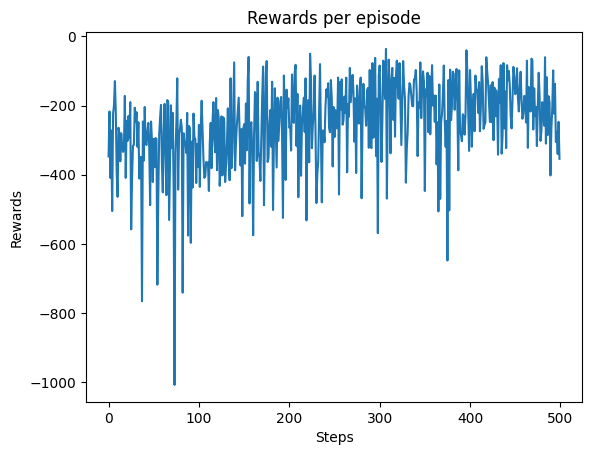

In [ ]:
env = GoldDigger(n_episodes=500, epsilon=1.0, alpha=0.001, gamma=0.9)
env.Qlearning()
rewards_sum = env.sum_rewards()
visualize_curve(rewards_sum)

**Drugi eksperyment**

Wykorzystane parametry:
- alpha=0.01
- gamma=0.9
- n_episodes=500
- epsilon=1.0

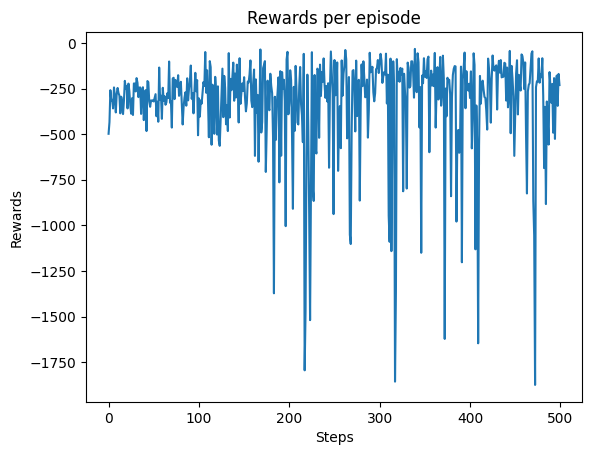

In [ ]:
env = GoldDigger(n_episodes=500, epsilon=1.0, alpha=0.01, gamma=0.9)
env.Qlearning()
rewards_sum = env.sum_rewards()
visualize_curve(rewards_sum)

## **Wnioski**



Podczas wykonywanych eksperymentów zauważalna jest różnica w wykonywanym czasie. Pierwszy wykonywał się najszybciej, a drugi wolniej. Spoglądając na powyższe wykresy można wywnioskować, że im mniejsza wartość `alpha` tym agent lepiej się uczy w kolejnych rozgrywkach.